In [88]:
import pandas as pd
import os
import time
from pathlib import Path
import gc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import FR
from dateutil.relativedelta import relativedelta

import cudf
import numba
from numba import cuda
import numpy as np
import numerapi
import matplotlib.pyplot as plt

# parallelize the process on all columns using joblib
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import lightgbm as lgb
from scipy import stats

from signals_lite.data.data_utils import (
    load_recent_data_from_file,
    save_daily_data,
    save_in_folders,
    get_latest_date,
    read_available_dates
)
from signals_lite.constants import (
    DAILY_DATA_DIR,
    DATA_DIR,
    DAILY_PRIMARY_FEATURES_DIR,
    DAILY_SECONDARY_FEATURES_DIR,
    DAILY_SCALED_FEATURES_DIR,
)


In [2]:
MERGED_HISTORICAL_DATA_LOCATION = os.path.join(DATA_DIR, "merged_data_historical.parquet")
LIVE_DATA_LOCATION = os.path.join(DATA_DIR, "merged_data_live.parquet")

In [3]:
ml_data = pd.read_parquet(MERGED_HISTORICAL_DATA_LOCATION)
live_data = pd.read_parquet(LIVE_DATA_LOCATION)

#ml_data = ml_data.groupby("date").filter(lambda x: len(x) > 500)

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class BaselineModel(RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 1. Provided Train-validation splits

In [80]:
train_set = ml_data[ml_data["data_type"] == "train"].copy()
val_set = ml_data[ml_data["data_type"] == "validation"].copy()

feature_names = [c for c in train_set.columns if "feature_" in c]
target_names = [c for c in train_set.columns if "target_" in c]

TARGET_NAME = "target_20d"
PREDICTION_NAME = "signal"

print(f"Using {len(feature_names)} features")


Using 101 features


In [94]:
lgbm_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.01,
    n_jobs=-1,
    random_state=42,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
)

lgbm_model.fit(
    ml_data[feature_names],
    ml_data[TARGET_NAME],
)   

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, n_estimators=200,
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5)

In [95]:
preds_train = lgbm_model.predict(train_set[feature_names])
preds_val = lgbm_model.predict(val_set[feature_names])
preds_live = lgbm_model.predict(live_data[feature_names])

train_set.loc[:, PREDICTION_NAME] = preds_train
val_set.loc[:, PREDICTION_NAME] = preds_val
live_data.loc[:, PREDICTION_NAME] = preds_live

train_set.loc[:, PREDICTION_NAME] = train_set.groupby("date")[PREDICTION_NAME].transform(lambda x: x.rank(pct=True))
val_set.loc[:, PREDICTION_NAME] = val_set.groupby("date")[PREDICTION_NAME].transform(lambda x: x.rank(pct=True))
live_data.loc[:, PREDICTION_NAME] = live_data.groupby("date")[PREDICTION_NAME].transform(lambda x: x.rank(pct=True))

In [96]:
def numerai_corr(preds, target):
  # rank (keeping ties) then Gaussianize predictions to standardize prediction distributions
  ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
  gauss_ranked_preds = stats.norm.ppf(ranked_preds)
  
  # make targets centered around 0
  centered_target = target - target.mean()
  
  # raise both preds and target to the power of 1.5 to accentuate the tails
  preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
  target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
  
  # finally return the Pearson correlation
  return np.corrcoef(preds_p15, target_p15)[0, 1]

In [97]:
train_scores = train_set.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)
val_scores = val_set.groupby("date").apply(
    lambda x: numerai_corr(x[PREDICTION_NAME], x[TARGET_NAME])
)

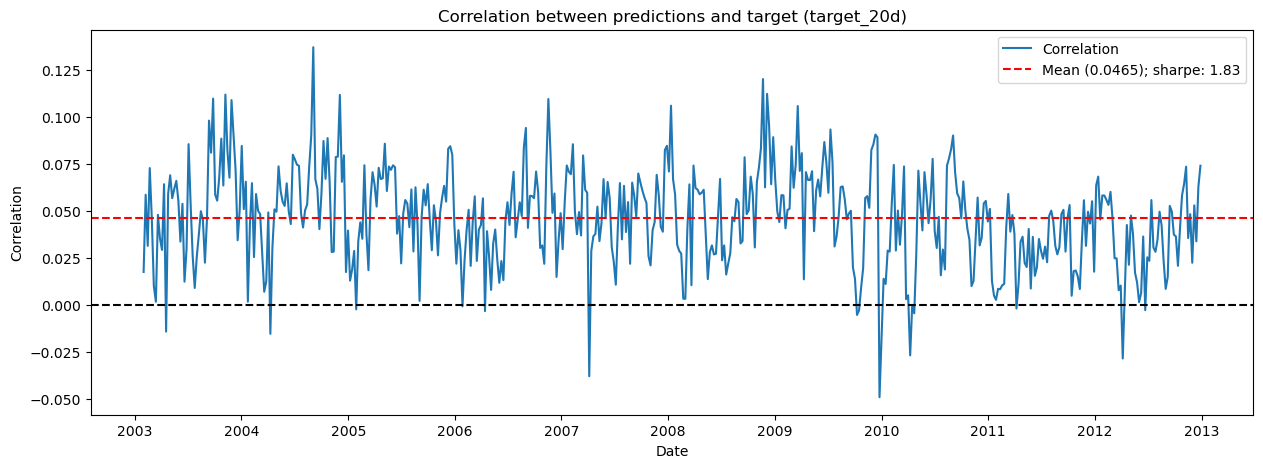

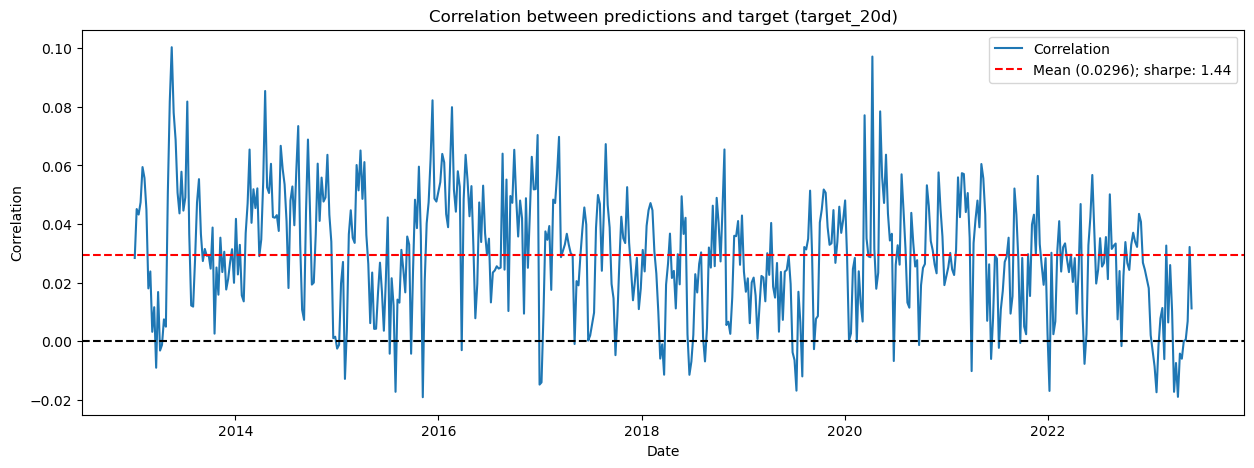

In [98]:
def plot_scores(scores, rolling_window=1):
    plt.figure(figsize=(15, 5))
    plt.plot(scores.rolling(rolling_window).mean(), label="Correlation")
    plt.title(f"Correlation between predictions and target ({TARGET_NAME})")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    _mean = scores.mean()
    plt.axhline(_mean, color="red", linestyle="--", label=f"Mean ({_mean:.4f}); sharpe: {scores.mean() / scores.std():.2f}")
    plt.axhline(0, color="black", linestyle="--")
    plt.legend()
    plt.show()


plot_scores(train_scores)
plot_scores(val_scores)

In [100]:
last_friday = datetime.now() + relativedelta(weekday=FR(-1))

diagnostic_df = pd.concat([val_set, live_data], axis=0)
diagnostic_df = diagnostic_df.drop_duplicates(
    subset=["bloomberg_ticker", "friday_date", "data_type"]
)
diagnostic_df["friday_date"] = diagnostic_df.friday_date.fillna(
    last_friday.strftime("%Y%m%d")
).astype(int)
diagnostic_df["data_type"] = diagnostic_df.data_type.fillna("live")

diagnostic_df[PREDICTION_NAME] = diagnostic_df.groupby("date")[PREDICTION_NAME].rank(
    pct=True, method="first"
)

diagnostic_df[["bloomberg_ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv(
    f"predictions/signals_lgbm_200_train_val_set_{time.strftime('%Y%m%d_%H%M%S')}.csv",
    index=False,
)
